(3, 288, 288)


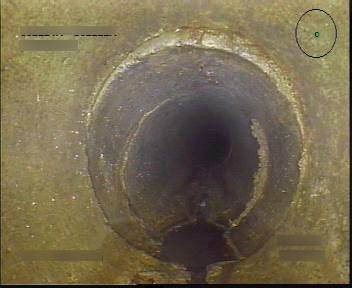

In [201]:
# load data
from PIL import Image
import numpy as np
import os
# rescale images to 288x288 (compression is better than expansion) - MAKE FUNCTION

datalocation = "C:/Users/Daniel Polania/OneDrive - University of Calgary/ENGG-680-ProjectDataDestination/"
files = list(set(os.listdir(datalocation)) - {'desktop.ini', 'whatever.ini'})
im = Image.open(f"{datalocation}{files[1]}")
w, h = im.size
rw, rh = (288/w, 288/h)
imRsz = im.resize((int(im.width * rw), int(im.height * rh)), resample=1)
imArr = np.array(imRsz, dtype=np.float32).transpose((2, 0, 1))
# transpose inputs Cin, Hin, Win

print(imArr.shape)
im

In [199]:
# fset = set(files)
# prefix = "C:/Users/Daniel Polania/OneDrive - University of Calgary/ENGG-680-Project/data/"
# filenames = pd.read_excel(f"{prefix}Combined excel.xlsx", usecols="A,B,C,D,R,U,V")
# filenames = filenames.set_index("Filename")
# import os

# for file in fset:
#     attrib = file.split("_")
#     name = attrib[0]+".png"
#     OSvalue = filenames.loc[name, "OS"]
#     newattrib = attrib[0] +"_"+ attrib[1] +"_"+ attrib[2][0] + str(OSvalue) + attrib[2][2:]
#     os.rename(f"{datalocation}{file}", f"{datalocation}{newattrib}")

# print("Done rename.")


Done rename.


In [233]:
fileLabels = {}
for file in files:
    attrib = file.split("_")
    fileLabels[file] = {"va":attrib[1], "defectLabel":attrib[2][2], "crackLabel":attrib[2][0],  "lrcLabel":attrib[2][1]}
fileLabels

{'00745580_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '00506614_1_101.png': {'va': '1',
  'defectLabel': '1',
  'crackLabel': '1',
  'lrcLabel': '0'},
 '00277249_0_101.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '1',
  'lrcLabel': '0'},
 '01119151_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '01137307_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '01109019_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '00584415_0_101.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '1',
  'lrcLabel': '0'},
 '00012059_1_000.png': {'va': '1',
  'defectLabel': '0',
  'crackLabel': '0',
  'lrcLabel': '0'},
 '00525102_0_011.png': {'va': '0',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '01106996_1_011.png': {'va': '1',
  'defectLabel': '1',
  'crackLabel': '0',
  'lrcLabel': '1'},
 '01140883_1_000.png

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame.from_dict(fileLabels, orient='index')
df.head()
df["defectLabel"] = df.defectLabel.astype(np.uint16)
df["crackLabel"] = df.crackLabel.astype(np.uint16)
df["lrcLabel"] = df.lrcLabel.astype(np.uint16)

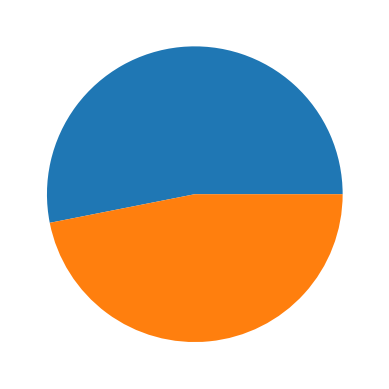

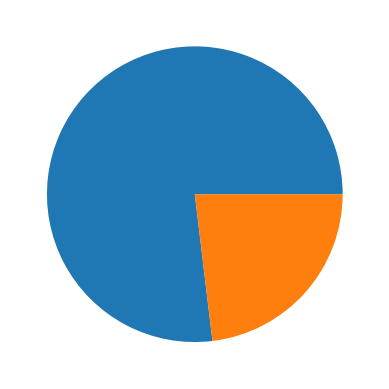

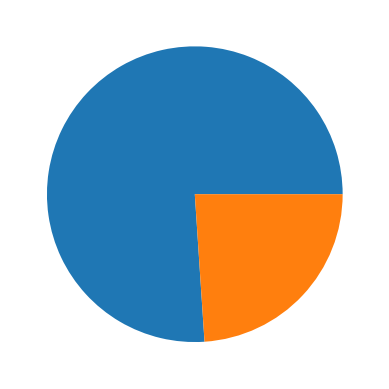

In [237]:
describeDefects = df.defectLabel.value_counts() 
describeDefects
plt.pie(describeDefects)
plt.show()

describeCracks = df.crackLabel.value_counts() 
describeCracks
plt.pie(describeCracks)
plt.show()

describeLatcut = df.lrcLabel.value_counts() 
describeLatcut
plt.pie(describeLatcut)
plt.show()

In [145]:
set(list(df.defectLabel))


{'0', '1'}

In [ ]:
df.crackLabel.astype(np.uint16)
df.va.astype(np.float)

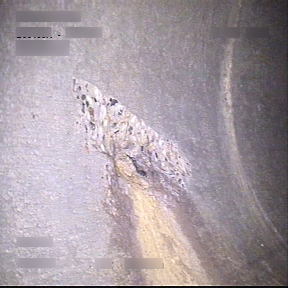

In [98]:
imRsz

In [76]:
import torch
import torch.nn  as nn
import torch.nn.functional as F

class aMeijerNet(nn.Module):
  def __init__(self):
    super(aMeijerNet, self).__init__()
    # input layer - 288x288x3
    # convolution layer - kernel 5x5 depth 32 ELU activation
    self.conv = nn.Conv2d(3, 32, kernel_size = 5, padding=2)
    self.elu = nn.ELU()
    # pooling layer - kernel 2x2 stride 2x2
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    
    # convolution layer 2 - kernel 5x5 depth 32 ELU activation
    self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu2 = nn.ELU()
    # pooling layer 2 - kernel 2x2 stride 2x2
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # convulation layer 3 - kernel 5x5 depth 32 ELU activation
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
    self.elu3 = nn.ELU()
    # pooling layer 3 - kernel 2x2 stride 2x2
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    # dense layer 
    self.fc1 = nn.Linear(36, 512) # 32, 36, 36 -> 32, 36, 512
    # ELU activation
    self.elu4 = nn.ELU()
    # 50% dropout
    self.do1 = nn.Dropout1d(p=0.5)
        
    # dense layer 32, 36, 512
    self.fc2 = nn.Linear(512, 512) 
    
    # ELU activation
    self.elu5 = nn.ELU()
    
    # 50% dropout
    self.do2 = nn.Dropout1d(p=0.5)
    
    # dense layer 32, 36, 512
    self.fc3 = nn.Linear(512, 512) 
    
    # ELU activation
    self.elu6 = nn.ELU()
    
    # 50% dropout
    self.do3 = nn.Dropout1d(p=0.5)
    
    # output layer - 3 outputs (defect, cracks, LRCs) - sigmoid and round for each output, binary step function, etc.
    self.out = nn.Linear(589824, 3)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    c = self.conv(x)
    e = self.elu(c)
    p = self.pool(e)
    
    c2 = self.conv2(p)
    e2 = self.elu2(c2)
    p2 = self.pool2(e2)
    
    c3 = self.conv3(p2)
    e3 = self.elu3(c3)
    p3 = self.pool3(e3)
    
    fc1 = self.fc1(p3)
    e4 = self.elu4(fc1)
    do1 = self.do1(e4)
    
    fc2 = self.fc2(do1)
    e5 = self.elu5(fc2)
    do2 = self.do2(e5)
    
    fc3 = self.fc3(do2)
    e6 = self.elu6(fc3)
    do3 = self.do3(e6)
    
    out = self.sigm(self.out(torch.flatten(do3)))
    outNum = np.round(out.detach().numpy(), decimals=0)
    
    return outNum

net = aMeijerNet()
print(net(torch.from_numpy(imArr)))

[1. 0. 0.]


In [64]:
32* 36*36

41472